# CASACV Project

## Load MRI data

In [2]:
import os
import pylab as plt

t1_file = os.path.join(os.getcwd(), "mri_data", "T1_preprocessed.nii.gz")
t2_file = os.path.join(os.getcwd(), "mri_data", "T2_preprocessed.nii.gz")
flair_file = os.path.join(os.getcwd(), "mri_data", "FLAIR_preprocessed.nii.gz")

import nibabel as nib
t1_img = nib.load(t1_file)
t2_img = nib.load(t2_file)
flair_img = nib.load(flair_file)

t1_data = t1_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()

## T1, T2 and FLAIR modalities

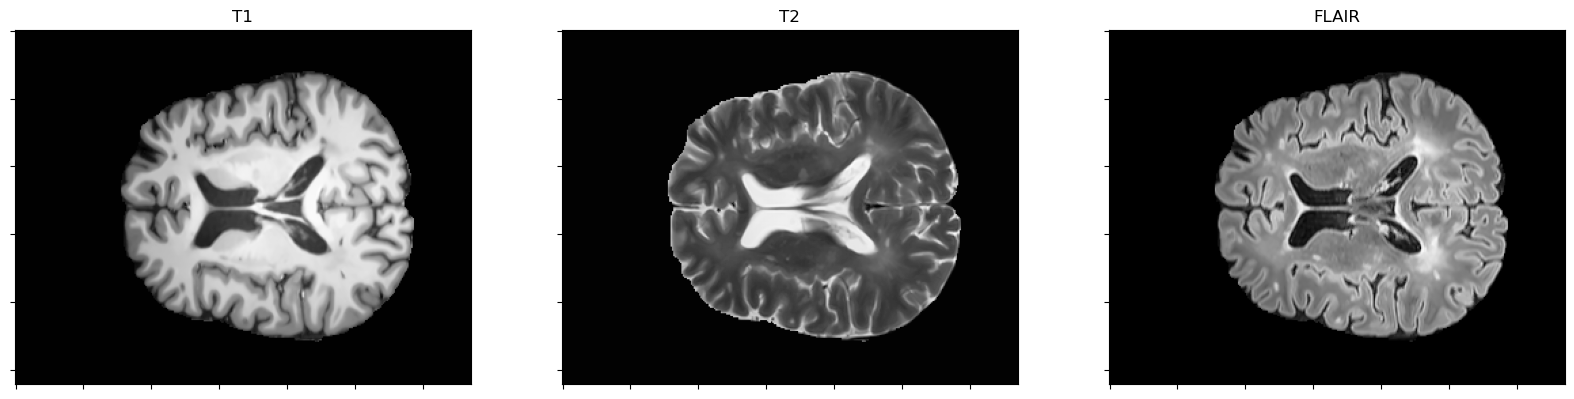

In [3]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(1, 3, 1)
ax1.title.set_text('T1')
ax1.set_yticklabels([])
ax1.set_xticklabels([])
plt.imshow(t1_data[:, :, 218], cmap="Greys_r")

ax2 = fig.add_subplot(1, 3, 2)
ax2.title.set_text('T2')
ax2.set_yticklabels([])
ax2.set_xticklabels([])
plt.imshow(t2_data[:, :, 218], cmap="Greys_r")

ax3 = fig.add_subplot(1, 3, 3)
ax3.title.set_text('FLAIR')
ax3.set_yticklabels([])
ax3.set_xticklabels([])
plt.imshow(flair_data[:, :, 218], cmap="Greys_r")

## Crop images

As can be seen in the above images, a large parte of the image is just black background. This background is not useful for the purposes of the project, so we can remove it. By removing it we also decrease the size of the images, which should improve the time taken by the next processing steps.

In [96]:
from PIL import Image
import numpy as np

def compute_bounding_boxes_for_modality(data, size):
    bounding_pixels_for_slice = [(0, 0, 0, 0)] * size

    for s in range(size):
        image_slice = data[:, :, s]

        image = Image.fromarray(image_slice.astype(np.uint8))
        image_pixels = list(image.getdata())

        max_row = image.height
        max_col = image.width

        first_nonblack_row = 0
        last_nonblack_row = 0
        first_nonblack_col = 0
        last_nonblack_col = 0

        for row in range(max_row):
            for col in range(max_col):
                idx = col + (row * max_col)

                if image_pixels[idx] > 0:
                    if first_nonblack_col == 0 or first_nonblack_col > col:
                        first_nonblack_col = col
                    if last_nonblack_col == 0 or last_nonblack_col < col:
                        last_nonblack_col = col
                    last_nonblack_row = row
                    if first_nonblack_row == 0:
                        first_nonblack_row = row
            
        bounding_pixels_for_slice[s] = (first_nonblack_row, last_nonblack_col, last_nonblack_row, first_nonblack_col)

    return bounding_pixels_for_slice

def get_max_bounding_box(bounding_boxes, max_x, max_y):
    top = len(bounding_boxes)

    first_nonblack_row = max_y
    first_nonblack_col = max_x
    last_nonblack_row = 0
    last_nonblack_col = 0

    for i in range(1, top):
        if bounding_boxes[i] == (0, 0, 0, 0): continue

        if bounding_boxes[i][0] < first_nonblack_row:
            first_nonblack_row = bounding_boxes[i][0]

        if bounding_boxes[i][1] > last_nonblack_col:
            last_nonblack_col = bounding_boxes[i][1]

        if bounding_boxes[i][2] > last_nonblack_row:
            last_nonblack_row = bounding_boxes[i][2]
        
        if bounding_boxes[i][3] < first_nonblack_col:
            first_nonblack_col = bounding_boxes[i][3]

    max_bounding_box = (first_nonblack_col, first_nonblack_row, last_nonblack_col, last_nonblack_row)

    return max_bounding_box


# to crop the images, first we need to compute the bounding boxes for each slice
bounding_boxes_t1 = compute_bounding_boxes_for_modality(t1_data, t1_img.shape[2])
bounding_boxes_t2 = compute_bounding_boxes_for_modality(t2_data, t2_img.shape[2])
bounding_boxes_flair = compute_bounding_boxes_for_modality(flair_data, flair_img.shape[2])

# then we have to compute a bounding box that fits all other bounding boxes
max_bounding_box_t1 = get_max_bounding_box(bounding_boxes_t1, t1_img.shape[1], t1_img.shape[0])
max_bounding_box_t2 = get_max_bounding_box(bounding_boxes_t2, t2_img.shape[1], t2_img.shape[0])
max_bounding_box_flair = get_max_bounding_box(bounding_boxes_flair, flair_img.shape[1], flair_img.shape[0])

print("max bounding box T1\t", max_bounding_box_t1)
print("max bounding box T2\t", max_bounding_box_t2)
print("max bounding box FLAIR\t", max_bounding_box_flair)

max bounding box T1	 (76, 24, 302, 234)
max bounding box T2	 (76, 24, 302, 234)
max bounding box FLAIR	 (76, 24, 302, 234)


In [19]:
def normalize(im):
    # Normalize image to range 0..1
    min, max = im.min(), im.max()
    return (im.astype(float)-min)/(max-min)

def scale(im):
    return im * 255.999

def normalize_and_scale(im):
    return scale(normalize(im))

### Cropping results

T1
original dimensions:	336x261
cropped dimensions:	226x210
removed pixels:		40236
percentage difference:	45.88%
------------------------------
T2
original dimensions:	336x261
cropped dimensions:	226x210
removed pixels:		40236
percentage difference:	45.88%
------------------------------
FLAIR
original dimensions:	336x261
cropped dimensions:	226x210
removed pixels:		40236
percentage difference:	45.88%


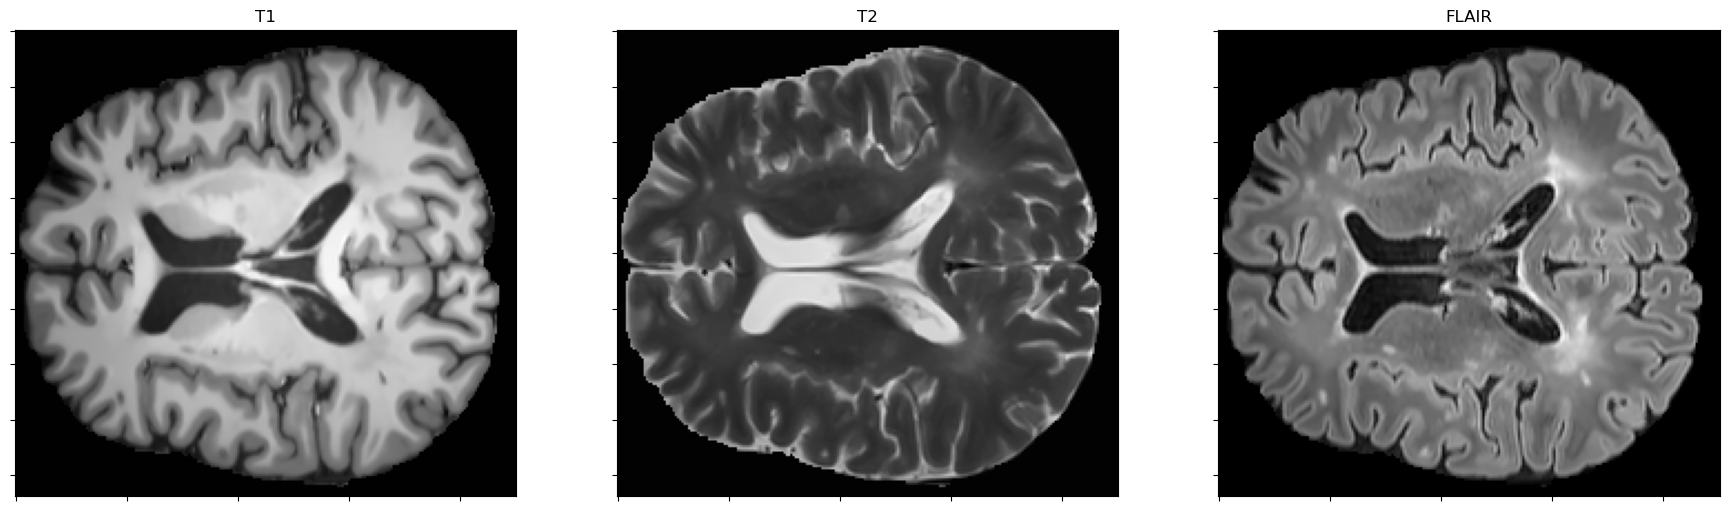

In [137]:
normalized_and_scaled_t1 = normalize_and_scale(t1_data[:, :, 218])
normalized_and_scaled_t2 = normalize_and_scale(t2_data[:, :, 218])
normalized_and_scaled_flair = normalize_and_scale(flair_data[:, :, 218])

original_t1 = Image.fromarray(normalized_and_scaled_t1)
cropped_t1 = original_t1.crop(max_bounding_box_t1)

original_t2 = Image.fromarray(normalized_and_scaled_t2)
cropped_t2 = original_t2.crop(max_bounding_box_t2)

original_flair = Image.fromarray(normalized_and_scaled_flair)
cropped_flair = original_flair.crop(max_bounding_box_flair)

fig = plt.figure(figsize=(22, 10))

ax1 = fig.add_subplot(1, 3, 1)
ax1.title.set_text('T1')
ax1.set_yticklabels([])
ax1.set_xticklabels([])
plt.imshow(cropped_t1, cmap="Greys_r")

ax2 = fig.add_subplot(1, 3, 2)
ax2.title.set_text('T2')
ax2.set_yticklabels([])
ax2.set_xticklabels([])
plt.imshow(cropped_t2, cmap="Greys_r")

ax3 = fig.add_subplot(1, 3, 3)
ax3.title.set_text('FLAIR')
ax3.set_yticklabels([])
ax3.set_xticklabels([])
plt.imshow(cropped_flair, cmap="Greys_r")

def get_percentage_difference(current, previous):
    return (abs(current - previous) / previous) * 100.0

print("T1")
print(f"original dimensions:\t{original_t1.width}x{original_t1.height}")
print(f"cropped dimensions:\t{cropped_t1.width}x{cropped_t1.height}")
original_t1_pixels = original_t1.height * original_t1.width
cropped_t1_pixels = cropped_t1.height * cropped_t1.width
t1_removed_pixels = original_t1_pixels - cropped_t1_pixels
print(f"removed pixels:\t\t{t1_removed_pixels}")
print("percentage difference:\t{:.2f}%".format(get_percentage_difference(cropped_t1_pixels, original_t1_pixels)))
print("------------------------------")
print("T2")
print(f"original dimensions:\t{original_t2.width}x{original_t2.height}")
print(f"cropped dimensions:\t{cropped_t2.width}x{cropped_t2.height}")
original_t2_pixels = original_t2.height * original_t2.width
cropped_t2_pixels = cropped_t2.height * cropped_t2.width
t2_removed_pixels = original_t2_pixels - cropped_t2_pixels
print(f"removed pixels:\t\t{t2_removed_pixels}")
print("percentage difference:\t{:.2f}%".format(get_percentage_difference(cropped_t2_pixels, original_t2_pixels)))
print("------------------------------")
print("FLAIR")
print(f"original dimensions:\t{original_flair.width}x{original_flair.height}")
print(f"cropped dimensions:\t{cropped_flair.width}x{cropped_flair.height}")
original_flair_pixels = original_flair.height * original_flair.width
cropped_flair_pixels = cropped_flair.height * cropped_flair.width
flair_removed_pixels = original_flair_pixels - cropped_flair_pixels
print(f"removed pixels:\t\t{flair_removed_pixels}")
print("percentage difference:\t{:.2f}%".format(get_percentage_difference(cropped_flair_pixels, original_flair_pixels)))

## RGB Images

Make RGB Images by using permutations of (T1, T2, FLAIR) on the R G B channels. 

For example, an image can be generated using T1 on the R channel, T2 on the G channel and FLAIR on the B channel.
Values of the pixels for each modality need to be normalized and scaled before computing the RGB image.

In [132]:
from PIL import Image
import numpy as np

RGB_IMAGES_OUTPUT_FOLDER = os.path.join(os.getcwd(), "rgb_images")

my_array = np.array([np.asarray(cropped_t1),  np.asarray(cropped_t2), np.asarray(cropped_flair)])

def index_to_type(index):
    if index == 0: return "T1"
    if index == 1: return "T2"
    if index == 2: return "FLAIR"

from pathlib import Path
Path(RGB_IMAGES_OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)

# compute permutations
for x in range(3):
    for y in range(3):
        for z in range(3):
            if x == y or x == z or z == y: continue

            permuted_array = my_array[[x, y, z]]

            result = np.dstack((permuted_array[0], permuted_array[1], permuted_array[2]))
            result = Image.fromarray(result.astype(np.uint8))

            result_name = index_to_type(x) + '_' + index_to_type(y) + '_' + index_to_type(z) + '.png'
            result_final_path = os.path.join(RGB_IMAGES_OUTPUT_FOLDER, result_name)
            result.save(result_final_path)

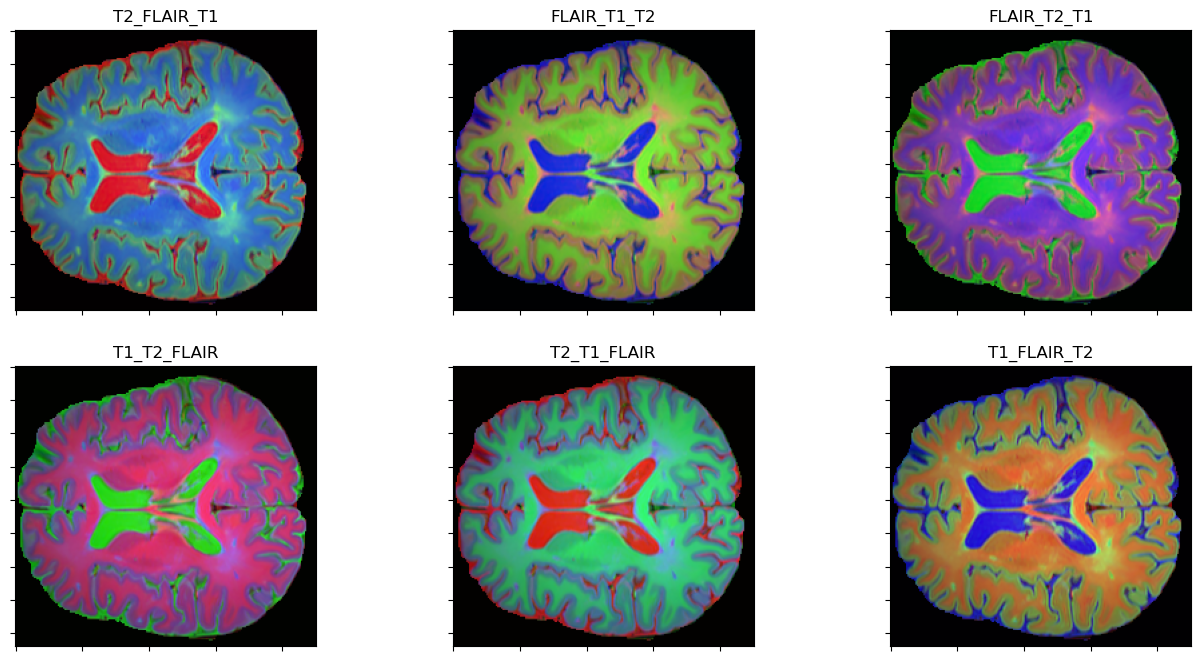

In [135]:
fig = plt.figure(figsize=(16, 8))
columns = 3
rows = 2
i = 1

def drop_extension_from_filename(filename):
    return os.path.splitext(filename)[0]

for filename in os.listdir(RGB_IMAGES_OUTPUT_FOLDER):
    with (Image.open(os.path.join(RGB_IMAGES_OUTPUT_FOLDER, filename))) as image:
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(drop_extension_from_filename(filename))
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        plt.imshow(np.asarray(image))
        i = i + 1

plt.show()

## Graph class

The graph will be represented by an adjacency list.

In [146]:
class Node:
    def __init__(self, value):
        self.vertex = value
        self.next = None
        self.weight = None

class Graph:
    def __init__(self, num):
        self.V = num
        self.graph = [None] * self.V

    def add_edge(self, s, d, w):
        node = Node(d)
        node.next = self.graph[s]
        node.weight = w
        self.graph[s] = node

    def __print_graph(self, file=None):
        for i in range(self.V):
            print("Vertex " + str(i) + ":", end="", file=file)
            temp = self.graph[i]
            while temp:
                print(" -> {}, w:{}".format(temp.vertex, temp.weight), end="", file=file)
                temp = temp.next
            print("", file=file)

    def print_graph(self):
        self.__print_graph()

    def print_graph_to_file(self, filename):
        with open(filename, 'w') as f:
            self.__print_graph(file=f)

## Build the graph for each RGB image previously generated

Edges where at least one vertex is a background pixel are omitted from the graph.

In [140]:
import math

def compute_pixel_graph(image):
    max_row = image.height
    max_col = image.width

    image = list(image.getdata())

    graph = Graph(len(image))

    def is_pixel_black(pixel):
        return pixel == (2, 0, 1) or pixel == (0, 1, 2) or pixel == (0, 2, 1) or pixel == (1, 2, 0) or pixel == (2, 1, 0) or pixel == (1, 0, 2)

    def compute_rgb_distance(rgb1, rgb2):
        r_sq = math.pow((rgb2[0] - rgb1[0]), 2)
        g_sq = math.pow((rgb2[1] - rgb1[1]), 2)
        b_sq = math.pow((rgb2[2] - rgb1[2]), 2)

        return math.sqrt(r_sq + g_sq + b_sq)

    def add_edges_for_adjacent_pixels(row, col):
        idx = col + (row * max_col)
        if row > 0 and col > 0:
            top_left_idx = (col - 1) + ((row - 1) * max_col)
            if not is_pixel_black(image[top_left_idx]):
                weight = compute_rgb_distance(image[idx], image[top_left_idx])
                graph.add_edge(idx, top_left_idx, weight)

        if row > 0:
            top_mid_idx = col + ((row - 1) * max_col)
            if not is_pixel_black(image[top_mid_idx]):
                weight = compute_rgb_distance(image[idx], image[top_mid_idx])
                graph.add_edge(idx, top_mid_idx, weight)

        if row > 0 and col < max_col - 1:
            top_right_idx = (col + 1) + ((row - 1) * max_col)
            if not is_pixel_black(image[top_right_idx]):
                weight = compute_rgb_distance(image[idx], image[top_right_idx])
                graph.add_edge(idx, top_right_idx, weight)

        if row < max_row - 1 and col != 0:
            bottom_left_idx = (col - 1) + ((row + 1) * max_col)
            if not is_pixel_black(image[bottom_left_idx]):
                weight = compute_rgb_distance(image[idx], image[bottom_left_idx])
                graph.add_edge(idx, bottom_left_idx, weight)

        if row < max_row - 1:
            bottom_mid_idx = col + ((row + 1) * max_col)
            if not is_pixel_black(image[bottom_mid_idx]):
                weight = compute_rgb_distance(image[idx], image[bottom_mid_idx])
                graph.add_edge(idx, bottom_mid_idx, weight)

        if row < max_row - 1 and col < max_col - 1:
            bottom_right_idx = (col + 1) + ((row + 1) * max_col)
            if not is_pixel_black(image[bottom_right_idx]):
                weight = compute_rgb_distance(image[idx], image[bottom_right_idx])
                graph.add_edge(idx, bottom_right_idx, weight)
        
        if col > 0:
            mid_left_idx = (col - 1) + (row * max_col)
            if not is_pixel_black(image[mid_left_idx]):
                weight = compute_rgb_distance(image[idx], image[mid_left_idx])
                graph.add_edge(idx, mid_left_idx, weight)
        
        if col < max_col - 1:
            mid_right_idx = (col + 1) + (row * max_col)
            if not is_pixel_black(image[mid_right_idx]):
                weight = compute_rgb_distance(image[idx], image[mid_right_idx])
                graph.add_edge(idx, mid_right_idx, weight)


    for row in range(max_row):
        for col in range(max_col):
            idx = col + (row * max_col)
            if not is_pixel_black(image[idx]):
                add_edges_for_adjacent_pixels(row, col)
    
    return graph

In [147]:
import os
from pathlib import Path

IMAGES_GRAPHS_OUTPUT_FOLDER = os.path.join(os.getcwd(), "graphs")

Path(IMAGES_GRAPHS_OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)

def drop_extension_from_filename(filename):
    return os.path.splitext(filename)[0]

for filename in os.listdir(RGB_IMAGES_OUTPUT_FOLDER):
    with (Image.open(os.path.join(RGB_IMAGES_OUTPUT_FOLDER, filename))) as image:
        graph = compute_pixel_graph(image)
        graph.print_graph_to_file(os.path.join(IMAGES_GRAPHS_OUTPUT_FOLDER, drop_extension_from_filename(filename) + ".txt"))